# Деревья решений решают проблемы
__Суммарное количество баллов: 10__

Вы уже знакомы с классификацией методом KNN. В этом задании предстоит реализовать другой метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений.

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib

## Задание 1 (1 балл)

Во время построения дерева решений нам потребуется определить, какой из предикатов лучше всего разбивает обучающую выборку. Есть два критерия, которые позволяют это сделать: критерий Джини и энтропийный критерий. Первый для подсчета информативности разбиения использует коэффициент Джини, второй - энтропию. Реализуйте подсчет этих коэффициентов, а так же подсчет информативности разбиения. 

#### Описание функций
`gini(x)` считает коэффициент Джини для массива меток

`entropy(x)` считает энтропию для массива меток

`gain(left_y, right_y, criterion)` считает информативность разбиения массива меток на левую `left_y` и правую `right_y` части при помощи `criterion`, который задается функцией (не строкой).

In [2]:
def gini(x):
    values, counts = np.unique(x, return_counts=True)
    return 1 - ((counts / x.shape[0]) ** 2).sum()


def entropy(x):
    values, counts = np.unique(x, return_counts=True)
    p = counts / x.shape[0]
    return -(p * np.log2(p)).sum()


def gain(left_y, right_y, criterion):
    n = left_y.shape[0] + right_y.shape[0]
    p_right = right_y.shape[0] / n
    p_left = left_y.shape[0] / n
    return (
        1 * criterion(np.concatenate((left_y, right_y), axis=None))
        - p_right * criterion(right_y)
        - p_left * criterion(left_y)
    )

## Задание 2 (1 балл)

Деревья решений имеют хорошую интерпретируемость, т.к. позволяют не только предсказать класс, но и объяснить, почему мы предсказали именно его. Например, мы можем его нарисовать. Чтобы сделать это, нам необходимо знать, как оно устроено внутри. Реализуйте классы, которые будут задавать структуру дерева. 

#### DecisionTreeLeaf
Поля:
1. `y` должно содержать класс, который встречается чаще всего среди элементов листа дерева

#### DecisionTreeNode
В данной домашней работе мы ограничемся порядковыми и количественными признаками, поэтому достаточно хранить измерение и значение признака, по которому разбиваем обучающую выборку.

Поля:
1. `split_dim` измерение, по которому разбиваем выборку
2. `split_value` значение, по которому разбираем выборку
3. `left` поддерево, отвечающее за случай `x[split_dim] < split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`
4. `right` поддерево, отвечающее за случай `x[split_dim] >= split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

__Интерфейс классов можно и нужно менять при необходимости__ (например, для вычисления вероятности в следующем задании)

In [3]:
class DecisionTreeLeaf:
    def __init__(self, ys):
        self.ys = None
        values, counts = np.unique(ys, return_counts=True)
        _id = counts.argmax()
        self.p = counts[_id] / ys.shape[0]
        self.y = values[_id]
        self.d = {cl: cou / ys.shape[0] for cl, cou in zip(values, counts)}

    def predict_proba_single(self, X):
        return self.d


class DecisionTreeNode:
    def __init__(self, ys, X, depth):
        print(ys.shape, X.shape)
        self.ys = ys
        self.X = X
        self.depth = depth
        self.left = None
        self.right = None
        self.value = None
        self.dim = None
        self.leaf = None
        

    def fit(self, max_depth, min_samples_leaf, criterion):
        best_feature_id = None
        best_value = None
        max_gain = -100
        X = self.X
        y = self.ys
        for feature_id in range(X.shape[1]):
            for value in np.unique(X[:, feature_id]):
                mask = X[:, feature_id] < value
                left_y = y[mask]
                right_y = y[~mask]
                split_gain = gain(left_y, right_y, criterion)
                if split_gain > max_gain:
                    max_gain = split_gain
                    best_feature_id = feature_id
                    best_value = value
                    # print(max_gain,mask.sum())
        if max_gain == 0:
            self.leaf = DecisionTreeLeaf(y)
            return
        self.dim = best_feature_id
        self.value = best_value
        mask = X[:, best_feature_id] < best_value
        left_y = y[mask]
        left_X = X[mask]
        right_y = y[~mask]
        right_X = X[~mask]
        print("best gain", max_gain)
        print("left", left_y.shape)
        print("right",right_y.shape)
        if self.depth and self.depth >= max_depth:
            self.left = DecisionTreeLeaf(left_y)
            self.right = DecisionTreeLeaf(right_y)
            return
        
        if left_y.shape[0] > min_samples_leaf:
            self.left = DecisionTreeNode(left_y, left_X, self.depth + 1)
            self.left.fit(max_depth, min_samples_leaf, criterion)
        else:
            self.left = DecisionTreeLeaf(left_y)
        if right_y.shape[0] > min_samples_leaf:
            self.right = DecisionTreeNode(right_y, right_X, self.depth + 1)
            self.right.fit(max_depth, min_samples_leaf, criterion)
        else:
            self.right = DecisionTreeLeaf(right_y)

    def predict_proba_single(self, X):
        if self.leaf:
            return self.leaf.predict_proba_single(X)
        if X[self.dim] < self.value:
            return self.left.predict_proba_single(X)
        else:
            return self.right.predict_proba_single(X)

## Задание 3 (6 баллов)

Теперь перейдем к самому дереву решений. Реализуйте класс `DecisionTreeClassifier`.

#### Описание методов
`fit(X, y)` строит дерево решений по обучающей выборке.

`predict_proba(X)` для каждого элемента из `X` возвращает словарь `dict`, состоящий из пар `(класс, вероятность)`. Вероятности классов в листе можно определить через количество объектов соответствующего класса в листе. 

#### Описание параметров конструктора
`criterion="gini"` - задает критерий, который будет использоваться при построении дерева. Возможные значения: `"gini"`, `"entropy"`.

`max_depth=None` - ограничение глубины дерева. Если `None` - глубина не ограничена

`min_samples_leaf=1` - минимальное количество элементов в каждом листе дерева.

#### Описание полей
`root` - корень дерева. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

In [4]:
class DecisionTreeClassifier:
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=2):
        self.root = None
        if criterion == "gini":
            self.criterion = gini
        elif criterion == "entropy":
            self.criterion = entropy
        else:
            raise ValueError
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf

    def fit(self, X, y):
        self.root = DecisionTreeNode(y, X, 0)
        self.root.fit(self.max_depth, self.min_samples_leaf, self.criterion)

    def predict_proba(self, X):
        return [self.root.predict_proba_single(x_s) for x_s in X]

    def predict(self, X):
        proba = self.predict_proba(X)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]

Построенное дерево можно нарисовать. Метод `draw_tree` рисует дерево и сохраняет его в указанный файл.

In [5]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1


def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        if not tree_root.leaf:
            x_center = (x_right - x_left) / 2 + x_left
            x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
            plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
            x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
            plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
            plt.text(
                x_center,
                y,
                "x[%i] < %f" % (tree_root.dim, tree_root.value),
                horizontalalignment="center",
            )
        else:
            plt.text(x_center, y, str(tree_root.leaf.y), horizontalalignment="center")
            
    else:
        plt.text(x_center, y, str(tree_root.y), horizontalalignment="center")
    return x_center


def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis("off")
    draw_tree_rec(tree.root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Для двумерного набора данных дерево можно отобразить на плоскости с данными. Кроме того, как и для любого классификатора, для него можно построить roc-кривую

In [6]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(
            sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0)
            / positive_samples
        )
        fpr.append(
            sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0)
            / (len(y_test) - positive_samples)
        )
    plt.figure(figsize=(7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()


def rectangle_bounds(bounds):
    return (
        (bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]),
        (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]),
    )


def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(
                tree_root.left,
                [bounds[0], [bounds[1][0], tree_root.split_value]],
                colors,
            )
            plot_2d_tree(
                tree_root.right,
                [bounds[0], [tree_root.split_value, bounds[1][1]]],
                colors,
            )
            plt.plot(
                bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0)
            )
        else:
            plot_2d_tree(
                tree_root.left,
                [[bounds[0][0], tree_root.split_value], bounds[1]],
                colors,
            )
            plot_2d_tree(
                tree_root.right,
                [[tree_root.split_value, bounds[0][1]], bounds[1]],
                colors,
            )
            plt.plot(
                (tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0)
            )
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])


def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y == c, 0], X[y == c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Задание 4 (2 балла)

Протестируйте решение на датасете spam.
Для этой задачи используйте данные x_spam_train и y_spam_train:
1. Выполните загрузку и предобработку файлов x_spam_train и y_spam_train.
2. Разбейте x_spam_train и y_spam_train на x_train, y_train, x_test и y_test для оценки точности работы алгоритма.
3. Посчитайте метрики `precision`, `recall`, `accuracy` для модели Decision Tree. Если необходимо, попробуйте разные наборы параметров для получения лучшего результата.
4. Сравните значения метрик с результатами модели kNN из предыдущего задания (можно использовать реализацию из библиотеки `sklearn`).
5. Ответьте на следующие вопросы:
    - Какой нужен препроцессинг данных для моделей?
    - Какая модель делает предсказания лучше?  Предположите, почему.

_Ваш ответ_

In [7]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from pathlib import Path

In [8]:
def load_train_dataset(BASE_PATH="/kaggle/input/homework-decision-tree-ib-22/"):
    df_train = pd.read_csv(Path(BASE_PATH) / "x_spam_train.csv")
    df_train = df_train.drop(columns=["Id"])
    df_test = pd.read_csv(Path(BASE_PATH) / "y_spam_train.csv")
    df_test = df_test.drop(columns=["Id"])
    return df_train.values, df_test.values.reshape(df_train.values.shape[0])

In [9]:
def load_test_dataset(BASE_PATH="/kaggle/input/homework-decision-tree-ib-22/"):
    df_test = pd.read_csv(Path(BASE_PATH) / "x_spam_test.csv")
    return df_test

In [10]:
x_spam_train,y_spam_train = load_train_dataset()
X_train,X_test, y_train, y_test = train_test_split(x_spam_train,y_spam_train,train_size=0.7,random_state=42,shuffle=True)
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X_train, y_train)

(2576,) (2576, 57)
best gain 0.15692494551933472
left (1491,)
right (1085,)
(1491,) (1491, 57)
best gain 0.07498430127555755
left (1383,)
right (108,)
(1383,) (1383, 57)
best gain 0.03024284946395192
left (1328,)
right (55,)
(1328,) (1328, 57)
best gain 0.013143037860431514
left (1248,)
right (80,)
(1248,) (1248, 57)
best gain 0.004972328899211231
left (1228,)
right (20,)
(1228,) (1228, 57)
best gain 0.002979137930547507
left (1213,)
right (15,)
(80,) (80, 57)
best gain 0.18137207425343016
left (59,)
right (21,)
(59,) (59, 57)
best gain 0.06568783127243344
left (52,)
right (7,)
(55,) (55, 57)
best gain 0.12429839520748598
left (28,)
right (27,)
(108,) (108, 57)
best gain 0.13193665045516903
left (99,)
right (9,)
(99,) (99, 57)
best gain 0.01828384858687894
left (35,)
right (64,)
(35,) (35, 57)
best gain 0.13224489795918346
left (7,)
right (28,)
(64,) (64, 57)
(1085,) (1085, 57)
best gain 0.12170931431051049
left (422,)
right (663,)
(422,) (422, 57)
best gain 0.09842330658022197
left (3

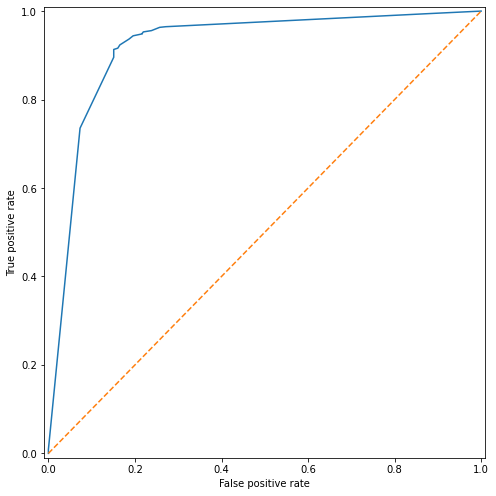

In [11]:
plot_roc_curve(y_test, tree.predict_proba(X_test))
# draw_tree(tree)

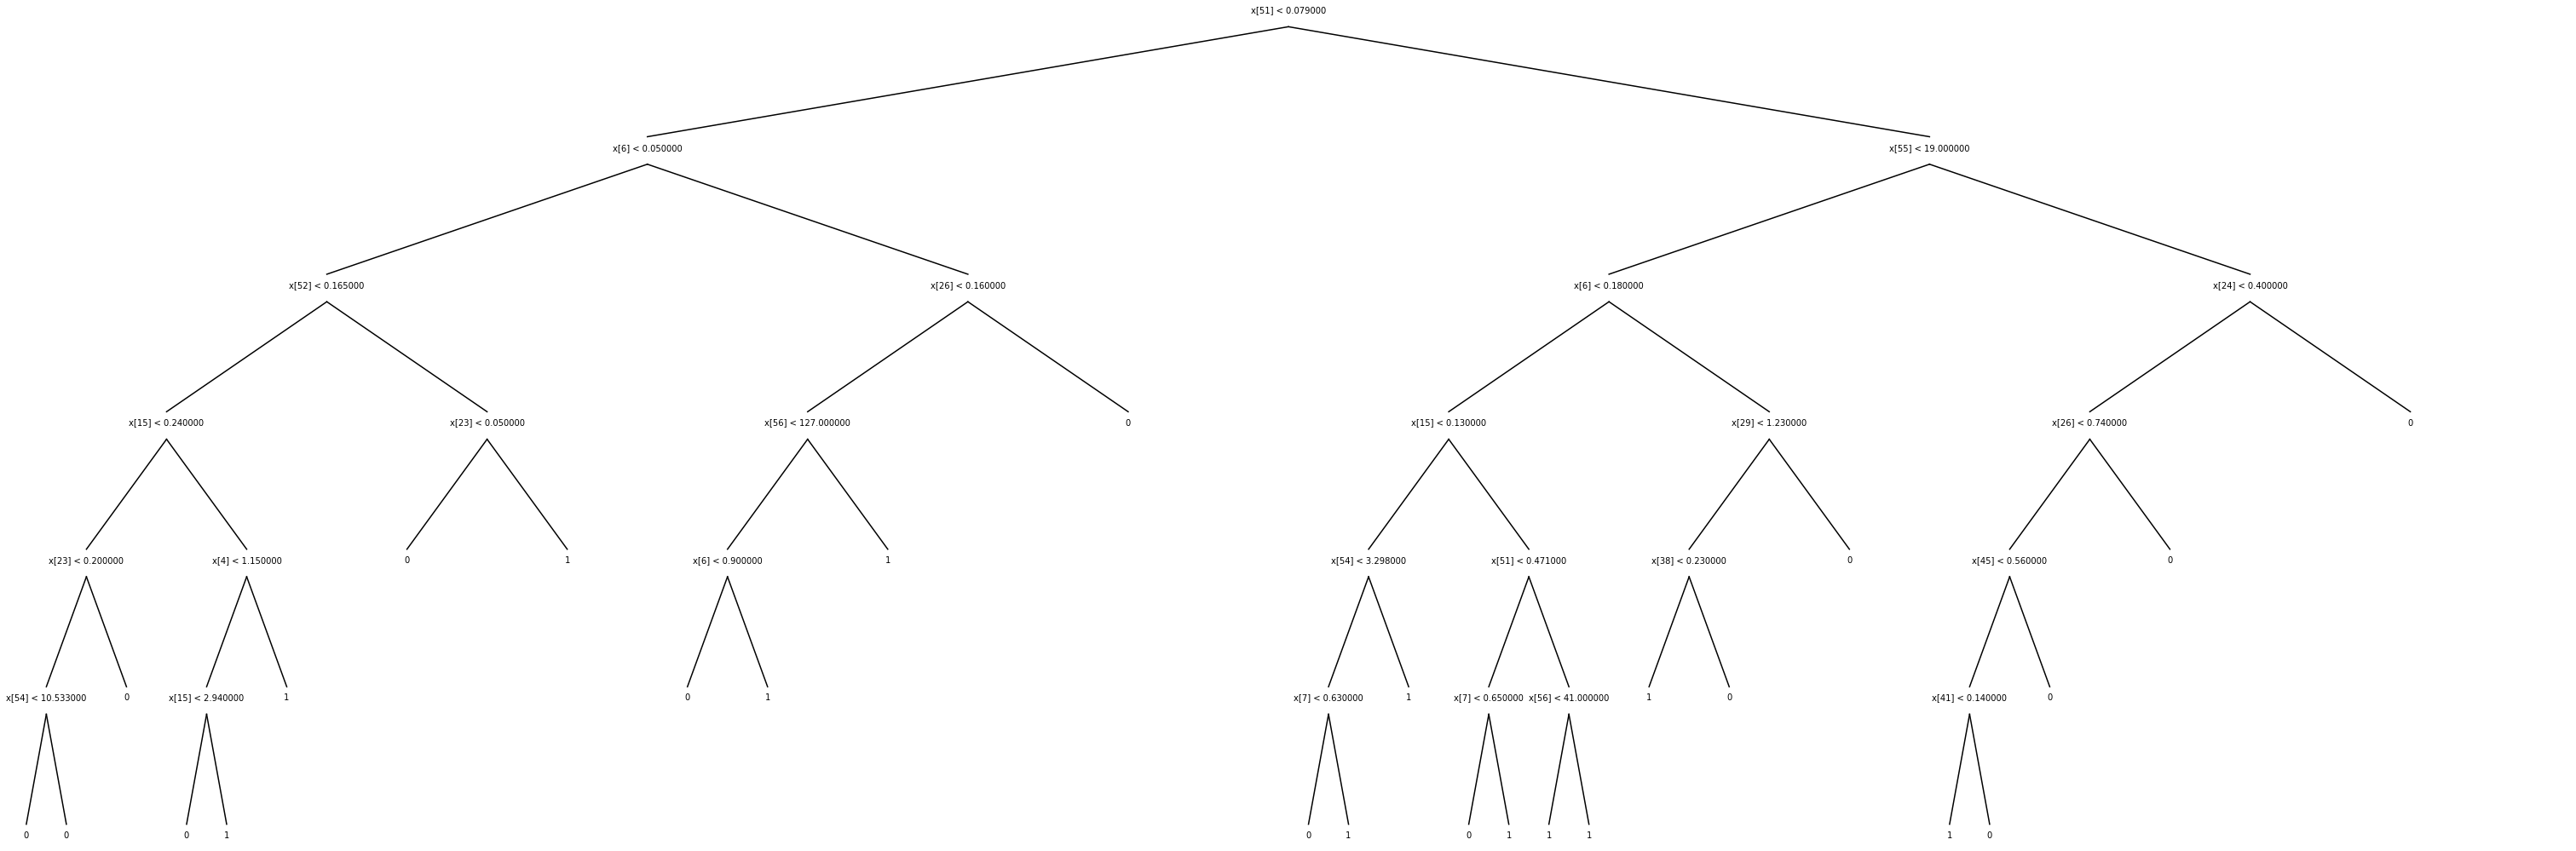

In [12]:
draw_tree(tree)

Результаты на валидации:

In [13]:
print(f"precision: {precision_score(y_test, tree.predict(X_test))}")
print(f"recall: {recall_score(y_test, tree.predict(X_test))}")
print(f"f1: {f1_score(y_test, tree.predict(X_test))}")

precision: 0.907103825136612
recall: 0.7830188679245284
f1: 0.8405063291139241


### knn

In [14]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3,metric='cosine')
knn.fit(X_train, y_train)
print(f"precision: {precision_score(y_test, knn.predict(X_test))}")
print(f"recall: {recall_score(y_test, knn.predict(X_test))}")
print(f"f1: {f1_score(y_test, knn.predict(X_test))}")

precision: 0.736
recall: 0.8679245283018868
f1: 0.7965367965367965


### Naive Bayes

Можно попробовать наивный байес, причем фичи преобразовать в булевы.

In [15]:
from sklearn.naive_bayes import ComplementNB
nb = ComplementNB()
nb.fit(X_train>0,y_train)
print(f"precision: {precision_score(y_test, nb.predict(X_test>0))}")
print(f"recall: {recall_score(y_test, nb.predict(X_test>0))}")
print(f"f1: {f1_score(y_test, nb.predict(X_test>0))}")

precision: 0.8265524625267666
recall: 0.910377358490566
f1: 0.866442199775533


In [16]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

nb.fit(X_train>0,y_train)
print(f"precision: {precision_score(y_test, nb.predict(X_test>0))}")
print(f"recall: {recall_score(y_test, nb.predict(X_test>0))}")
print(f"f1: {f1_score(y_test, nb.predict(X_test>0))}")

precision: 0.8529411764705882
recall: 0.8891509433962265
f1: 0.8706697459584296


1. Обучите модель на всех данных из x_spam_train и y_spam_train.
2. Сделайте submit своего решения и получите значение f1_score не менее 0.6

In [17]:
x_spam_train,y_spam_train = load_train_dataset()
final_tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
final_tree.fit(x_spam_train, y_spam_train)

(3680,) (3680, 57)
best gain 0.15527363236315803
left (2145,)
right (1535,)
(2145,) (2145, 57)
best gain 0.0669906874334906
left (2001,)
right (144,)
(2001,) (2001, 57)
best gain 0.033227186463162195
left (1924,)
right (77,)
(1924,) (1924, 57)
best gain 0.012577078316321419
left (1799,)
right (125,)
(1799,) (1799, 57)
best gain 0.0060318305197107625
left (1755,)
right (44,)
(1755,) (1755, 57)
best gain 0.0023406197717370097
left (1101,)
right (654,)
(44,) (44, 57)
best gain 0.15619834710743802
left (30,)
right (14,)
(125,) (125, 57)
best gain 0.13637420452985577
left (94,)
right (31,)
(94,) (94, 57)
best gain 0.04436396559529204
left (47,)
right (47,)
(31,) (31, 57)
best gain 0.2084248660731488
left (4,)
right (27,)
(77,) (77, 57)
best gain 0.1003544188780005
left (38,)
right (39,)
(38,) (38, 57)
best gain 0.23335180055401672
left (25,)
right (13,)
(39,) (39, 57)
best gain 0.04996712689020377
left (38,)
right (1,)
(38,) (38, 57)
(144,) (144, 57)
best gain 0.11679299521953032
left (133,

In [18]:
x_spam_test = load_test_dataset()

submission = pd.DataFrame(columns = ["Id", "Expected"])
submission["Id"] = x_spam_test.pop("Id")
submission["Expected"] = final_tree.predict(x_spam_test.values)
submission.to_csv('submission.csv', index=False)


In [19]:
submission

,Id,Expected
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
916,916,1
917,917,0
918,918,1
919,919,0


Ответы:

1. Препроцессинг для наших данных не требуется. В общем случае, в зависимости от реализации, нужно закодировать категоральные переменные.
2. Для этих данных решающее дерево лучше, они разреженные, подготовленные с помощью TF-IDF(или чем-то подобным). Я бы еще попробовал Naive Bayes или Complement Naive Bayes. Для более подробного сравнения моделей нужно поподбирать гиперпараметры, пока видно ,что knn  хуже(подобрал только метрику и количество соседей). Наивный Байес сравнимо и/или лучше.
